In [1]:
%load_ext autoreload
%autoreload 2    
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob
import config
import pandas as pd 

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')



flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


In [2]:
#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))


### Load salinity data and success/failure of runs

##### Find data files

In [3]:
# job_id = 3573022
# case='SV'

job_id = 3573239
case='NM'

## Find AEM data files
ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id)).as_posix())
its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])

output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
f_varlist = Path('../data/PriorModel/varlist.pkl')
varlist = load_obj(f_varlist.parent,'varlist')

ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id)).as_posix())
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
success_AEM = np.array([True if it in its_AEM else False for it in its_tds])
failed = totims<14782
its_failed = its_tds[failed]
its_success = its_tds[~failed]

strange = [(it in its_failed) for it in its_AEM]
if np.any(strange):
    print('something weird here... failed seawat run ended up with AEM data?')
    
print('Case: {}\nNumber of SEAWAT runs: {} \nFailure rate: {} %'.format(case,len(failed),np.round(100*sum(failed)/len(failed),2)))


Case: NM
Number of SEAWAT runs: 498 
Failure rate: 0.8 %


##### Load the data

In [4]:
print('loading...')
'''
d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
'''
# d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
# d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


# d_AEM = np.zeros((500,2940),dtype=np.float) 
flag=0
for f,it_AEM in zip(aempaths,its_AEM):
    if flag==0:
        matshape_AEM = np.load(f).shape
        matsize_AEM= np.prod(matshape_AEM)
        d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
        flag=1
    d_AEM[it_AEM] = np.load(f,allow_pickle=True)


flag=0
for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):        
    if it_inAEM:
        if flag==0:
            matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
            matsize_conc = np.prod(matshape_conc)
            d_conc = np.zeros((max(its_tds+1),matsize_conc))
            flag=1
        d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()

        

#Verify that mats have missing rows in same indices
if np.all((np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0])):
    print('matrices line up!')
else:
    print('Warning: matrices do not line up!')        
        
        
keep_inds = np.where(d_conc.any(axis=1))[0]
d_AEM = -d_AEM[keep_inds,:]
d_conc = d_conc[keep_inds,:]

its_AEM = np.sort(its_AEM)
its_tds = np.sort(its_tds[success_AEM])

loading...
matrices line up!


In [5]:
#Load AEM data
d_obs = np.load(datadir.joinpath('AEM','dobs_{}.npy'.format(case)))
area_304 = 337.04
invalid_msk= d_obs==9999./area_304
invalid_inds = np.unique(np.r_[np.where(invalid_msk)[0], np.where(np.isnan(d_AEM[0,:]))[0]])

#Load AEM times
times_HM_304 = np.load(datadir.joinpath('AEM','times_HM_304.npy'))
times_LM_304 = np.load(datadir.joinpath('AEM','times_LM_304.npy'))



#Take the log
d_obs=np.log(d_obs)
d_AEM=np.log(d_AEM)

#Remove invalid data
d_conc[d_conc>100]=0.
d_obs[invalid_inds]=0.
d_AEM[:,invalid_inds]=0.
d_obs_stash = d_obs.copy()


##### Load in SEAWAT model geometry

In [6]:
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5
nmgwmdir_cal_empty = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty')

m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal_empty.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


In [7]:
##Loading
it=1
model_ws = workdir.joinpath('{}_{}'.format(case,it))

modelname = case
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)
# thinmsk_in_aqt = np.load(model_ws.joinpath('thinmsk_in_aqt.npy'))
# wellmsk_in_aqt = np.load(model_ws.joinpath('wellmsk_in_aqt.npy'))
topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
topo_grid_fine = np.loadtxt(GISdir.joinpath('Topography_fine','TopographyMesh_vertices.csv'),skiprows=1,delimiter=',')

if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)


m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())
flopy.modflow.ModflowDis(m_empty, m.nlay, m.nrow, m.ncol, nper=m.nper, delr=m.dis.delr,
                               delc=m.dis.delc,
                               laycbd=0, top=m.dis.top,
                               botm=m.dis.botm, perlen=m.dis.perlen, nstp=m.dis.nstp,
                               steady=m.dis.steady,itmuni=m.dis.itmuni,lenuni=m.dis.lenuni,
                               tsmult=m.dis.tsmult)

xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]





m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


##### Load in TDS data

In [12]:
method = 'simple' #'full'


df_TDS = pd.read_excel(datadir.joinpath('WQ','export_TDS_data.xlsx'))
TDSij =[]
for x,y in zip(df_TDS.X_NAD83_UTM10N.values,df_TDS.Y_NAD83_UTM10N.values):
    try:
        TDSij.append(m_empty.modelgrid.intersect(x,y))
    except:
        TDSij.append((np.nan,np.nan))
df_TDS = df_TDS.assign(rowi=np.array(TDSij)[:,0])
df_TDS = df_TDS.assign(colj=np.array(TDSij)[:,1])


#Keep only valid data
tds_data_msk = np.logical_and(~np.logical_or(np.isnan(df_TDS.rowi),np.isnan(df_TDS.colj)),
                              df_TDS.perf_end1_elev>-200)
df_TDS = df_TDS.loc[tds_data_msk,:]
df_TDS = df_TDS.reset_index(drop=True)


#Find layers corresponding to screened interval
z_vert = m_empty.modelgrid.zvertices


top_vert_ind = np.zeros(len(df_TDS),dtype=int)
bot_vert_ind = np.zeros(len(df_TDS),dtype=int)
vert_ind_array = []
inds_raveled = []


for i in range(len(df_TDS)):
    entry = df_TDS.iloc[i]
    #Get indices
    top_vert_ind[i] =  np.argmin(np.abs(entry.perf_start1_elev -  z_vert[:,int(entry.rowi),int(entry.colj)]))
    bot_vert_ind[i] = np.argmin(np.abs(entry.perf_end1_elev -  z_vert[:,int(entry.rowi),int(entry.colj)]))
    if top_vert_ind[i]==bot_vert_ind[i]:
        top_vert_ind[i]-=1
    vert_ind_array.append(np.arange(top_vert_ind[i],bot_vert_ind[i]))
    
    
    inds_raveled.append(np.ravel_multi_index(((vert_ind_array[i]).astype(int),
                                 (np.ones(len(vert_ind_array[i]))*entry.rowi).astype(int),
                                 (np.ones(len(vert_ind_array[i]))*entry.colj).astype(int))
                                ,matshape_conc))
    if len(inds_raveled[i])==0:
        print(i)
    
# vert_ind_array = [np.arange(top,bot) for top,bot in zip(top_vert_ind,bot_vert_ind)]
df_TDS = df_TDS.assign(top_vert_ind=top_vert_ind)
df_TDS = df_TDS.assign(bot_vert_ind=bot_vert_ind)
df_TDS = df_TDS.assign(vert_ind_array=vert_ind_array)
df_TDS = df_TDS.assign(inds_raveled=inds_raveled)


#Get observed TDS
d_tds_obs = np.reshape(df_TDS.loc[:,'conc'].values/1000,(1,-1))


#Get available times
fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(its_AEM[0]))][0]
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times_sim = ucnobj.get_times()
times_real = float(starttime) + np.array(times_sim)/365



#Collect data from synthetic models
if method=='simple':
    #Collect data from synthetic models
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,c in enumerate(d_conc):
        for j,loc in enumerate(df_TDS.inds_raveled.values):
            d_tds[i,j] = c[loc].mean()
elif method=='pickyear':
    time_rec = 2010.3
    loadtime_ind = np.argmin(np.abs(time_rec-times_real))

    
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,it in enumerate(its_AEM):
        if i%10==0:
            print(i)
        fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(it))][0]
        ucnobj = flopy.utils.binaryfile.UcnFile(fname)
        load_conc = ucnobj.get_data(totim=times[loadtime_ind]).flatten()
        for j,loc in enumerate(df_TDS.inds_raveled.values):
            d_tds[i,j] = load_conc[loc].mean()
    
elif method=='full':
    loadtime_ind = []
    for i in range(len(df_TDS)):
        entry = df_TDS.date_rec.iloc[i]
        time_rec = entry.year  + entry.month/12
        loadtime_ind.append(np.argmin(np.abs(time_rec-times_real)))

    df_TDS = df_TDS.assign(loadtime_ind=loadtime_ind)
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,it in enumerate(its_AEM):
        if i%10==0:
            print(i)
        fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(it))][0]
        ucnobj = flopy.utils.binaryfile.UcnFile(fname)
        for tim_ind in df_TDS.loadtime_ind.unique():
            load_conc = ucnobj.get_data(totim=times[tim_ind])
            applytoinds = (tim_ind==df_TDS.loadtime_ind)[tim_ind==df_TDS.loadtime_ind].index.values
            for j in applytoinds:
                d_tds[i,j] = load_conc.flatten()[df_TDS.inds_raveled.values[j]].mean()


In [13]:
import psutil
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)


5.1
94.88365599655833


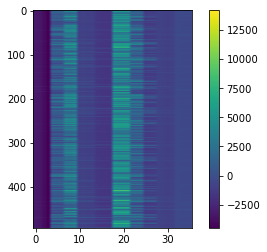

In [15]:
plt.imshow((d_tds[:,:] - d_tds_obs[:,:])*1000)
plt.gca().set_aspect(.1)
plt.colorbar()





##### Load TDS data to correspond to the correct simulated time (takes forever!!)

In [67]:
from sklearn.covariance import MinCovDet as MCD
mcd = MCD(random_state=0).fit(d_pri_pca)
new_obs = d_obs_pca-mcd.location_
md_obs= np.sqrt(new_obs.dot(np.linalg.inv(mcd.covariance_)).dot(new_obs.T))
print('Robust Mahalanobis Distance of d_obs = ', md_obs[0,0].round(decimals = 3))
md_samples=[]
for i in range(len(d_pri_pca)):
    sample = d_pri_pca[i:i+1, :]-mcd.location_
    md_samp = np.sqrt(sample.dot(np.linalg.inv(mcd.covariance_)).dot(sample.T))[0,0]
    md_samples.append(md_samp)
md_samples = np.asarray(md_samples)


print(str(Q_quantile)+'th Quantile of Robust Mahalanobis Distance is', \
      stats.scoreatpercentile(md_samples, Q_quantile).round(decimals=3))

/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Robust Mahalanobis Distance of d_obs =  1.097475764368473e+32


NameError: name 'Q_quantile' is not defined

  
4. Prior falsification


/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Robust Mahalanobis Distance of d_obs =  1.097475764368473e+32
95th Quantile of Robust Mahalanobis Distance is 14805.285
  
******************************************************
 >> "test" Prior is falsified! Please re-design your prior <<
******************************************************
*******************************
>> "test" Prior CANNOT be falsified!
*******************************


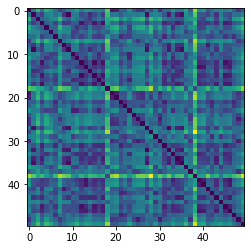

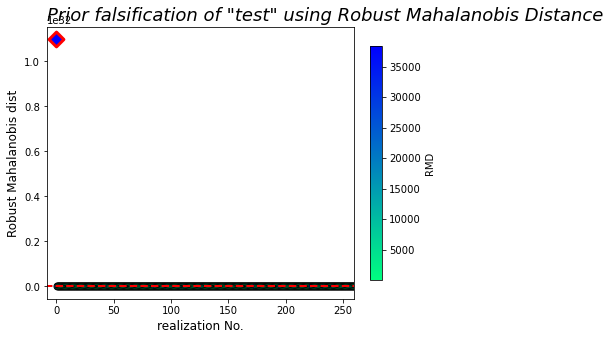

In [52]:
from scipy.spatial.distance import pdist,squareform
distmat = squareform(pdist(np.r_[d_tds,d_tds_obs]))
plt.imshow(distmat[-50:,-50:])



model_names = ['test',]
print("  ")
print("4. Prior falsification")
for i in range(len(model_names)):   
    RMD_obs, RMD_Qquantile = RobustMD_flsification(d_pri_pca, d_obs_pca, model_names[i], True, 95)

    if RMD_obs >= RMD_Qquantile:
        print("  ")
        print("******************************************************")
        print(' >> "'+model_names[i]+'" Prior is falsified! Please re-design your prior <<')
        print("******************************************************")
    print("*******************************")
    print('>> "'+model_names[i]+'" Prior CANNOT be falsified!')
    print("*******************************")


array([-3136.91200856, -3296.91200856, -3836.91200856, -4456.91200856,
         890.93356092,   850.93356092,   865.93356092,  2683.11578768,
        2613.11578768,  2938.11578768,  -778.71996723,  -743.71996723,
        -848.71996723,  -796.71996723, -1347.10274482, -1427.10274482,
       -1473.10274482, -1480.10274482,  4275.88457134,  4079.88457134,
        4059.88457134,  4052.88457134,  1327.8006585 ,  1292.8006585 ,
        1292.8006585 ,  -737.67386703,  -640.67386703,  -640.67386703,
        -736.62322367,  -874.62322367,  -939.62322367,  -882.62322367,
        -386.19651607,  -391.19651607,  -391.19651607,  -391.19651607])

In [71]:
d_tds_obs.size

36

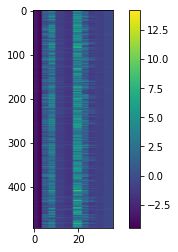

In [68]:
plt.imshow(d_tds - d_tds_obs)
plt.gca().set_aspect(.2)
plt.colorbar()



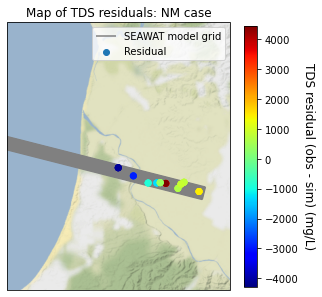

In [16]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

m_empty.modelgrid.plot(ax=ax,transform=transform,label='SEAWAT model grid')

ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)
s = plt.scatter(df_TDS.X_NAD83_UTM10N ,df_TDS.Y_NAD83_UTM10N,
                c=(d_tds_obs-d_tds).mean(axis=0)*1000,
#                 c=df_TDS.perf_start1_elev,
            zorder=10,cmap='jet',transform=transform,label='Residual')
plt.legend()
plt.title('Map of TDS residuals: NM case')


cax,kw = matplotlib.colorbar.make_axes(ax,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(s,cax=cax,**kw)
label=out.set_label('TDS residual (obs - sim) (mg/L)',size=12,rotation= -90,verticalalignment='bottom')


# plt.savefig(figdir.joinpath('NM_tds_residuals.png'),dpi=300,bbox_inches='tight')

##### Load in thickness of 180/400-FA or salinity of 180-FA

In [62]:
if case=='NM':
    pass
elif case=='SV':
    pass

##### Dim reduction

In [18]:
def reshapeAEM(d,values_to_nan=0.):
    d_reshaped = d.reshape((times_HM_304.size+times_LM_304.size, 83), order='F')
    d_reshaped[d_reshaped==values_to_nan] = np.nan
    return d_reshaped[:times_HM_304.size,:],d_reshaped[times_HM_304.size:,:]


In [15]:
i_line=71
n_lines=1
plt.semilogx(times_HM_304,dhm[:,i_line:i_line+n_lines],'k+',label='simulated')
plt.semilogx(times_LM_304,dlm[:,i_line:i_line+n_lines],'k+',label='simulated')

plt.semilogx(times_HM_304,dhm_obs[:,i_line:i_line+n_lines],'r',label='obs')
plt.semilogx(times_LM_304,dlm_obs[:,i_line:i_line+n_lines],'r',label='obs')


NameError: name 'dhm' is not defined

In [32]:
#FROM AUTOBEL

autobeldir = 'source_code/'
if autobeldir not in sys.path:
    sys.path.insert(0,autobeldir)
    
    
import numpy as np
from sklearn.decomposition import PCA

from source_code.scree_plot import scree_plot
from source_code.evd_fast import *
from source_code.RobustMD_flsification import RobustMD_flsification
from source_code.DGSA_light import DGSA_light
from source_code.gsa_pareto_plt import gsa_pareto_plt
# 

# from source_code.combine_mc_samples import *
# from source_code.signed_distance_functions import *
# from source_code.giip_cal import *

# from source_code.gd_wellog_data import gd_wellog_data
# from source_code.falsifications import fals_1Dplt, fals_2Dplt
# from source_code.outlier_detection import outlier_2d
# from source_code.rgrplt_all_dh import rgrplt_all_dh 
# from source_code.cca_and_ccaplt import cca_d_h
# from source_code.cca_and_ccaplt import cca_plt
# from source_code.gaussianregression_c_dd_star import *
# from source_code.post_est_rtn_val import post_est_rtn_val
# from source_code.post_est_rtn_val import post_est_clsplt
# from source_code.plt_pos_pri_comp import plt_pos_pri_comp
# from source_code.plt_MC_models_smpls import m_ensampl_plt
# from source_code.plt_MC_models_smpls import mc_samples_plot
# from source_code.qc_reslts_plt import m_ensampl_plt

'''
# model_names: names of the input models, type - list
model_names =['thickness']
# Define model type: 1 - Continous; 2 - Categorical
model_types = [1]
# Define model dimensions in x, y, z directions. 
x_dim, y_dim, z_dim = 200, 100, 1
# Define model horizontal resolution
grid_h_resolution = 250*250
# Provide directory of the prior models
pri_m_samples_dir = 'input/prior_samples/'
# Provide sample size of the prior models
samples_size = 250
# Provide directory of the global parameters
mgl = 'input/thickness_mgl.txt'
# Provide directory of the data observation
dobs_file = 'input/thickness_obs'
'''

"\n# model_names: names of the input models, type - list\nmodel_names =['thickness']\n# Define model type: 1 - Continous; 2 - Categorical\nmodel_types = [1]\n# Define model dimensions in x, y, z directions. \nx_dim, y_dim, z_dim = 200, 100, 1\n# Define model horizontal resolution\ngrid_h_resolution = 250*250\n# Provide directory of the prior models\npri_m_samples_dir = 'input/prior_samples/'\n# Provide sample size of the prior models\nsamples_size = 250\n# Provide directory of the global parameters\nmgl = 'input/thickness_mgl.txt'\n# Provide directory of the data observation\ndobs_file = 'input/thickness_obs'\n"

In [19]:
def eigen_imgs_local(eigen_vecs, eig_nums,matshape,slicenum=10):
    '''
    This is the function to plot the eigen_images
    arg:
        eigen_vecs: the ndarray of the eigen vectors
        eig_nums: 1d arrary defines which pc numbers to plot
        i_dim, j_dim: the i and j dimension of the grid model        
    '''
    plot_num = len(eig_nums)
    fig_row = int((plot_num+3)/4)
    fig=plt.figure(figsize=(15, fig_row*3))
    
    count = 1
    for i in eig_nums:
        plot=fig.add_subplot(fig_row, 4, count)
        count = count+1
        plt.imshow(eigen_vecs[:,i].reshape(matshape)[:,slicenum,:], cmap='jet')  
        plt.gca().set_aspect(7)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.title('model eigen_img (PC' + str(i) +')', fontsize = 14)
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    
    #t = (" ")
    #plt.figure(figsize=(3, 0.1))
    #plt.text(0, 0, t, style='normal', ha='center', fontsize=16, weight = 'bold')
    #plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    #plt.show()
    return

  
3. Dimension reduction of model and data
2020-07-07 11:11:21:946442
2020-07-07 11:11:47:272481
QC of the model eigen images


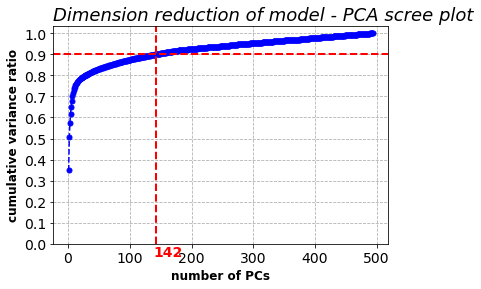

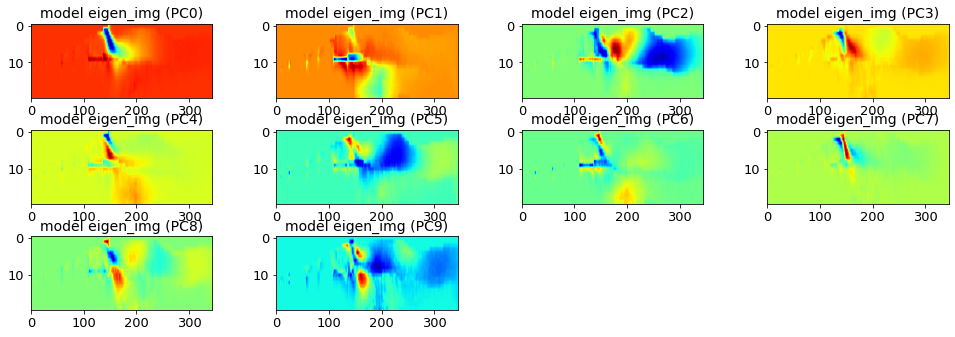

In [20]:
print("  ")
print("3. Dimension reduction of model and data")
'''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''

model_name = 'test'

m_pcnums = []
m_pri = d_conc

m_pcnum =scree_plot(m_pri, 'model', 90, 'plot')
m_pcnums.append(m_pcnum)
m_mean_pri = m_pri.mean(axis=0)
m_eigvec_pri = evd_fast(m_pri, len(m_pri))
m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)

output_model = outputdir.joinpath('BEL',case,'model')
output_data = outputdir.joinpath('BEL',case,'data')

if not output_model.exists():
    output_model.mkdir(parents=True)
if not output_data.exists():
    output_data.mkdir(parents=True)



    
np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)

print("QC of the model eigen images")
eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)


In [21]:
# d_pri = d_AEM.copy()
# d_pca = PCA().fit(d_pri)
# d_pcscr = d_pca.transform(d_pri)



d_pri = d_tds.copy()
d_obs = d_tds_obs.copy()
d_pca = PCA().fit(d_pri)
d_pcscr = d_pca.transform(d_pri)
d_pcscr_obs = d_pca.transform(d_obs)

np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr)
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_pca.components_)


  
4. Prior falsification


/home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Robust Mahalanobis Distance of d_obs =  6.245992019940125e+17
95th Quantile of Robust Mahalanobis Distance is 17429.713
  
******************************************************
 >> "test" Prior is falsified! Please re-design your prior <<
******************************************************
*******************************
>> "test" Prior CANNOT be falsified!
*******************************


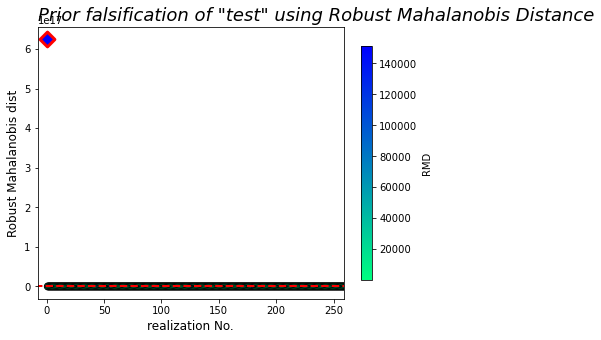

In [22]:
model_names = ['test',]
print("  ")
print("4. Prior falsification")
for i in range(len(model_names)):   
    d_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
    d_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))
    RMD_obs, RMD_Qquantile = RobustMD_flsification(d_pri, d_obs, model_names[i], True, 95)

    if RMD_obs >= RMD_Qquantile:
        print("  ")
        print("******************************************************")
        print(' >> "'+model_names[i]+'" Prior is falsified! Please re-design your prior <<')
        print("******************************************************")
    print("*******************************")
    print('>> "'+model_names[i]+'" Prior CANNOT be falsified!')
    print("*******************************")


In [30]:
model_names = ['test',]
##########################################################################
    ##           STEP 5. GSA               ##
##########################################################################
print("  ")
print("5. Global Sensitivity anlaysis-DGSA")
for i in range(len(model_names)):
    m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnums[i]]
    d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))

    headers = []
    for para in range(m_pcnums[i]):
        headers.append('pc' + str(para + 1))
    try:
        SA_measure = DGSA_light(m_pcscr_pri, d_pcscr, headers)
    except Exception as error:
        print(str(error))
    gsa_pareto_plt(SA_measure, model_names[i])
    np.save(output_data.joinpath('SA_measure_' + model_names[i]), SA_measure)


  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:29<00:00, 102.12it/s]


NameError: name 'gsa_pareto_plt' is not defined

In [51]:
np.save(output_data.joinpath('SA_measure_' + model_names[i] + '.npy'), SA_measure)

In [52]:
!ls -lr /scratch/users/ianpg/SWIlarge/work/output/BEL/NM/data

total 157
-rw-r--r-- 1 ianpg rknight 142400 Jul  7 11:11 test_dpcscr_pri.npy
-rw-r--r-- 1 ianpg rknight    416 Jul  7 11:11 test_dpcscr_obs.npy
-rw-r--r-- 1 ianpg rknight  10496 Jul  7 11:11 test_dpca_eigenvec.npy
-rw-r--r-- 1 ianpg rknight   1264 Jul  7 12:39 SA_measure_test.npy


In [50]:
np.load(output_data.joinpath('SA_measure_' + model_names[i]))


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/ianpg/SWIlarge/work/output/BEL/NM/data/SA_measure_test'

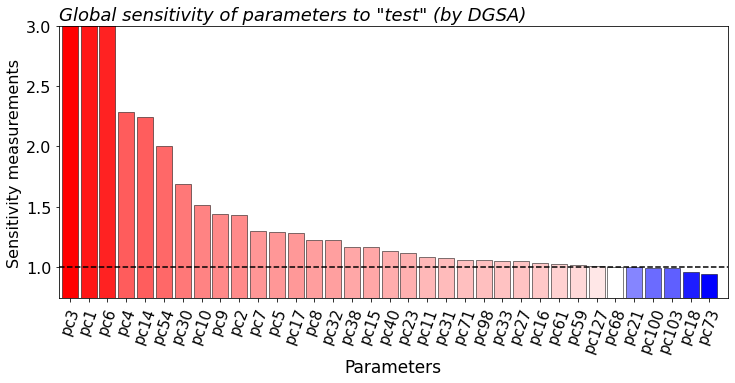

In [36]:
gsa_pareto_plt(SA_measure, model_names[i])

In [47]:
output_data

PosixPath('/scratch/users/ianpg/SWIlarge/work/output/BEL/NM/data')

In [53]:
##########################################################################
    ##           STEP 6.  Uncertainty reduction              ##
##########################################################################
print("  ")
print("6. Unceratinty reduction")
print("  ")
##########################################################################
##          STEP 6.1     QC statistical relationships           ##
print("6.1 QC model and data statistical relationships")
for i in range(len(model_names)):
    SA_measure = np.load(output_data.joinpath('SA_measure_' + model_names[i] + '.npy'))[:, 0]
    sensitive_pcnum = np.argwhere(SA_measure > 1)[:len(d_pcscr[1]), 0]

    m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnums[i]]
    d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
    d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))

    rgrplt_all_dh(d_pcscr_pri, m_pcscr_pri, d_pcscr_obs,
                  [1, 2, 3], [1, 2, 3, 4, 5, 6, 7])

    m_star = m_pcscr_pri[:, sensitive_pcnum]
    d_star = d_pcscr_pri
    dobs_star = d_pcscr_obs


  
6. Unceratinty reduction
  
6.1 QC model and data statistical relationships


NameError: name 'rgrplt_all_dh' is not defined

In [43]:
output_data.joinpath('SA_measure_' + model_names[i])

PosixPath('/scratch/users/ianpg/SWIlarge/work/output/BEL/NM/data/SA_measure_test')

In [38]:
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))

In [26]:
m_pcscr_pri.shape

(494, 494)

In [23]:
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_pca.components_)

np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))
np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))



['test']

In [66]:
from scipy.spatial.distance import pdist,squareform

In [67]:
# distmat = squareform(pdist(np.r_[d_AEM,d_obs.reshape(1,-1)],))
from scipy.spatial.distance import pdist,squareform
distmat = squareform(pdist(np.r_[d_pri,d_obs]))

In [153]:
maxind = np.argmax(distmat[-1,:-1])
its_AEM[maxind]

156

In [169]:
its_AEM[269]

280

In [168]:
np.where(distmat[-1,:-1]==np.sort(distmat[-1,:-1])[1])

(array([269]),)

In [68]:
minind = distmat[-1,:-1]
min_AEM = d_AEM[minind,:]

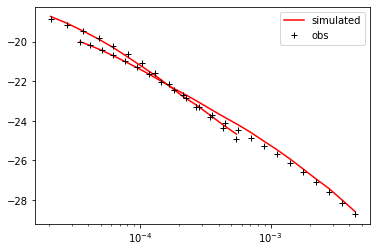

In [110]:
dHM,dLM = reshapeAEM(min_AEM)
dHMobs,dLMobs = reshapeAEM(d_obs_stash)

i_line=22
n_lines=1
plt.semilogx(times_HM_304,dHM[:,i_line:i_line+n_lines],'r',label='simulated')
plt.semilogx(times_LM_304,dLM[:,i_line:i_line+n_lines],'r')

plt.semilogx(times_HM_304,dHMobs[:,i_line:i_line+n_lines],'k+',label='obs')
plt.semilogx(times_LM_304,dLMobs[:,i_line:i_line+n_lines],'k+')
plt.legend()

In [109]:
diff_dbdt = np.abs(np.nanmin((dHM - dHMobs),axis=0))
diff_dbdt[np.isnan(diff_dbdt)]=100.
np.argmin(diff_dbdt)

22

In [112]:
its_AEM[minind]

406

In [115]:
case

'SV'

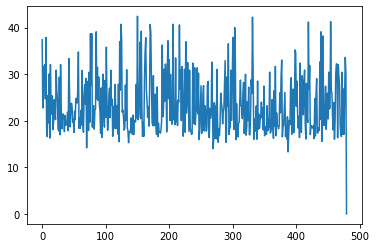

In [114]:
plt.plot(distmat[-1,:])


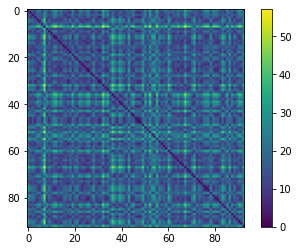

In [73]:
plt.imshow(distmat[minind:,minind:])
plt.colorbar()

(array([2.42000e+02, 7.25000e+02, 6.08800e+03, 1.49954e+05, 3.97700e+03,
        5.00000e+02, 5.50000e+01, 3.30000e+01, 1.40000e+01, 1.60000e+01]),
 array([-5.13202974e-09, -3.64171348e-09, -2.15139722e-09, -6.61080964e-10,
         8.29235295e-10,  2.31955155e-09,  3.80986781e-09,  5.30018407e-09,
         6.79050033e-09,  8.28081659e-09,  9.77113285e-09]),
 <a list of 10 Patch objects>)

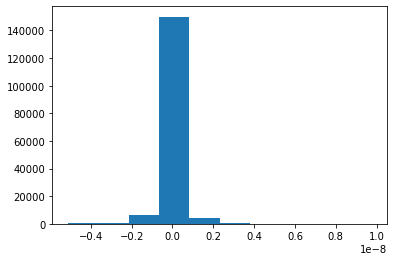

In [116]:
plt.hist((d_pri-d_obs).flatten())

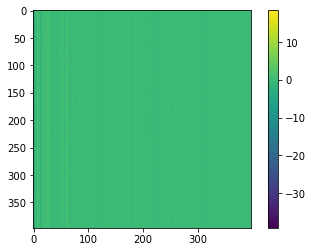

In [87]:
plt.imshow(d_pri-d_obs)
plt.colorbar()

##### Load observed data

##### Mahabonabonlis distance

In [ ]:
m_eigvec_pri.shape

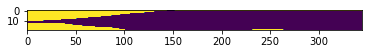

In [41]:
plt.imshow(d_conc[0].reshape(matshape_conc)[:,0,:])

### Plot

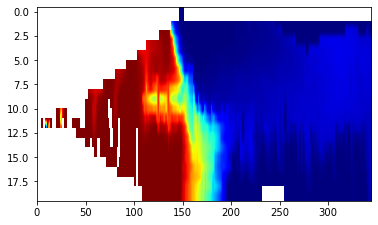

In [94]:
conc[conc>100]=np.nan

plt.imshow(conc[:,10,:],vmin=0,vmax=35.,cmap='jet')
plt.gca().set_aspect(10)

In [76]:
for f in ucn

TypeError: only integer scalar arrays can be converted to a scalar index

In [74]:
dd = {}

for 



233

In [59]:
data

In [19]:
ucnpaths = glob.glob(output_SV.joinpath('*_{}.UCN'.format(job_id)).as_posix())
f= ucnpaths[0]
f.split('_')

['/scratch/users/ianpg/SWIlarge/work/output/SV/conc75',
 '20200704',
 '1110',
 'totim14782',
 '3573022.UCN']

In [25]:
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
